<a href="https://colab.research.google.com/github/Subhoshri/Titanic-Survival-Prediction/blob/main/Titanic_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"up14cp9225","key":"fb2dc9c6bc4010df97628a90a762f1f3"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c titanic

In [6]:
!unzip /content/titanic.zip

Archive:  /content/titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [7]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Reading and Exploring Data

In [8]:
data=pd.read_csv('/content/train.csv')

In [9]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
data.shape

(891, 12)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [13]:
data.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


A lot of data is missing regarding the ages and cabins of passengers which makes sense because the records might have gotten lost in the disaster that occurred.

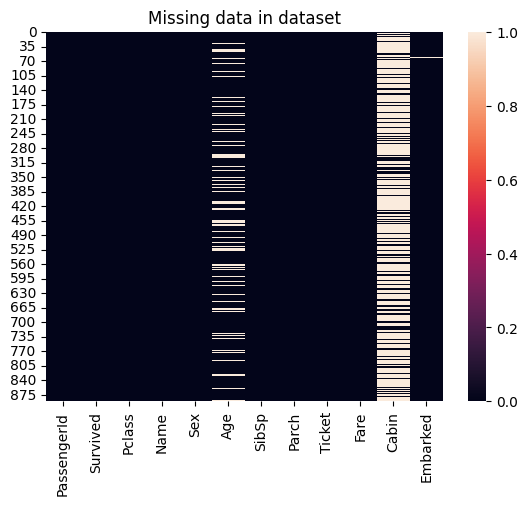

In [14]:
sns.heatmap(data.isnull())
plt.title("Missing data in dataset")
plt.show()

Let's drop the cabin column since majority data is missing and it doesn't add meaning to the model. Age is on the otherhand important, as children were focused during safety. Let's use median age for now for the missing values.

# Data Cleaning

In [15]:
data=data.drop(columns='Cabin')

In [16]:
data['Age']=data['Age'].fillna(data['Age'].median())
data['Embarked']=data['Embarked'].fillna(data['Embarked'].mode()[0])

There are no missing values now. We can also remove unnecessary columns like PassengerID or ticket which don't add value in predicting survivors.

In [17]:
data.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [18]:
data=data.drop(columns=['PassengerId', 'Ticket'])

Now we are done preprocessing our dataset, so we'll move onto analysing the dataset using Exploratory Data Analysis.

# Exploratory Data Analysis

## 1. Survival Rate vs Gender

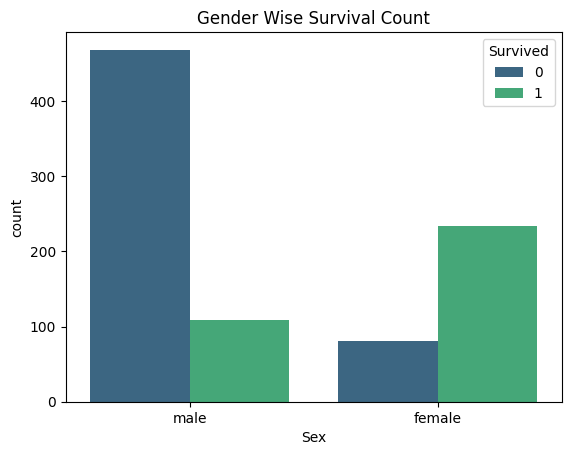

Sex
female    74.203822
male      18.890815
Name: Survived, dtype: float64


In [19]:
sns.countplot(x=data['Sex'],hue=data['Survived'],palette='viridis')
plt.title("Gender Wise Survival Count")
plt.show()

#Percentage survival
survived=data.groupby('Sex')['Survived'].mean()*100
print(survived)

74% females survived whereas only 18% men were able to survive.

## 2. Ages Distribution

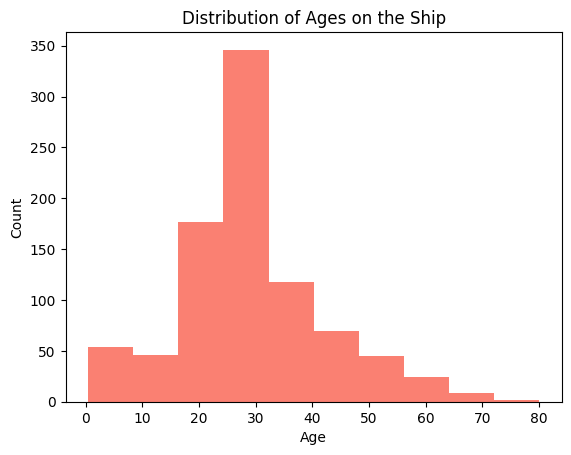

In [20]:
plt.hist(data['Age'],color='salmon')
plt.title("Distribution of Ages on the Ship")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

The age distribution is incorrect, due to our handling of missing values with median ages. However, majority of people where adults aboard.

## 3. Family Distribution: Parent/Child and Sibling/Spouse Presence

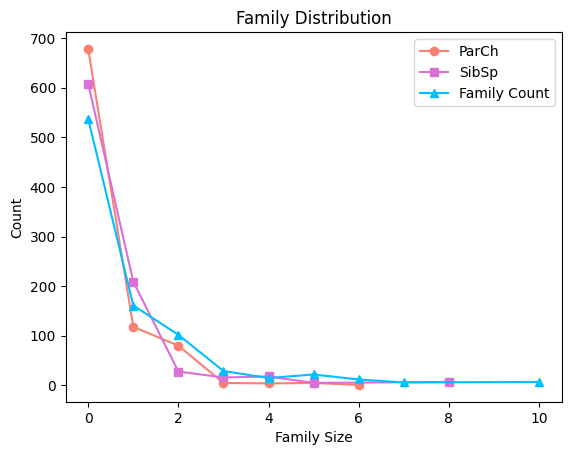

In [21]:
plt.plot(data['Parch'].value_counts().sort_index(), label='ParCh',color='salmon',marker='o')
plt.plot(data['SibSp'].value_counts().sort_index(), label='SibSp',color='orchid',marker='s')
family_counts = (data['Parch'] + data['SibSp']).value_counts().sort_index()
plt.plot(family_counts, label='Family Count',color='deepskyblue',marker='^')
plt.title("Family Distribution")
plt.xlabel("Family Size")
plt.ylabel("Count")
plt.legend()
plt.show()

Most passengers were either alone or had one family member, showing that large families were uncommon aboard due to high cost of tickets perhaps.

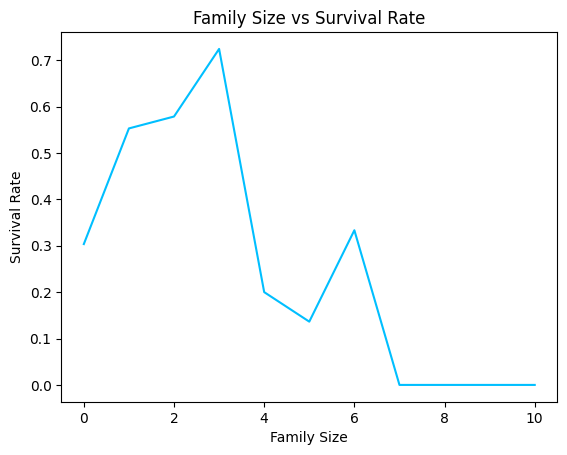

In [22]:
data['FamilySize']=data['SibSp']+data['Parch']
family_survive=data.groupby('FamilySize')['Survived'].mean()
plt.plot(family_survive, color='deepskyblue')
plt.title("Family Size vs Survival Rate")
plt.xlabel("Family Size")
plt.ylabel("Survival Rate")
plt.show()

Survival rate is higher for passengers who travelled alone or with 1-2 family members.

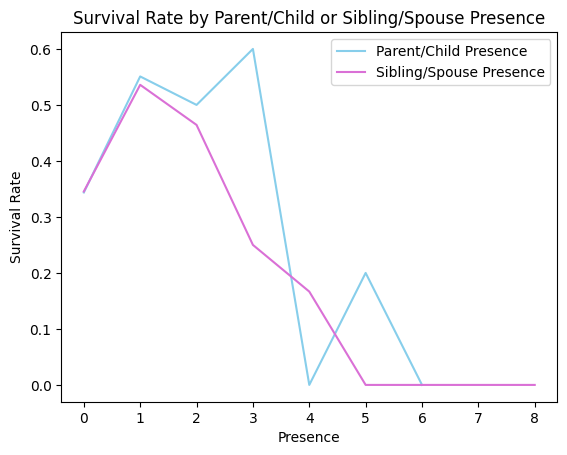

In [23]:
parch_survive=data.groupby('Parch')['Survived'].mean()
plt.plot(parch_survive, color='skyblue', label='Parent/Child Presence')
sibsp_survive=data.groupby('SibSp')['Survived'].mean()
plt.plot(sibsp_survive, color='orchid', label='Sibling/Spouse Presence')

plt.title("Survival Rate by Parent/Child or Sibling/Spouse Presence")
plt.legend()
plt.xlabel("Presence")
plt.ylabel("Survival Rate")
plt.show()

Let us now look at the correlation between Fare and PClass to identify wealth vs class relation

## 4. Fare vs Passenger Class

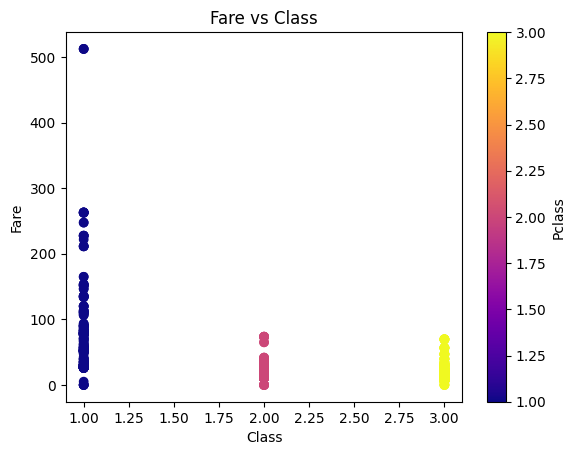

In [24]:
plt.scatter(data['Pclass'],data['Fare'], c=data['Pclass'],cmap='plasma')
plt.title("Fare vs Class")
plt.xlabel("Class")
plt.ylabel("Fare")
plt.colorbar(label='Pclass')
plt.show()

1st Class passengers usually paid more fare to get a better cabin. There are few outliers, especially with the fare being more than 500 for few passengers.

Let's look at the survival rates corresponding to factors like Pclass, Age, Embarked and heatmap to find the correlation of all factors.

## 5. Survival Rate vs Passenger Class

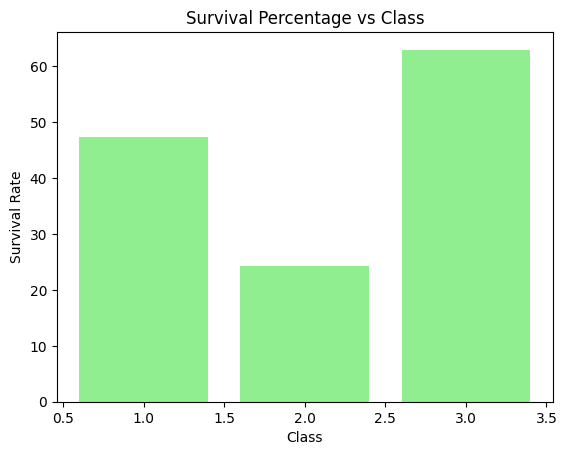

In [25]:
plt.bar(data['Pclass'].unique(), data.groupby('Pclass')['Survived'].mean()*100 ,color='lightgreen')
plt.title("Survival Percentage vs Class")
plt.xlabel("Class")
plt.ylabel("Survival Rate")
plt.show()

## 6. Survival Rate vs Embarked Shore

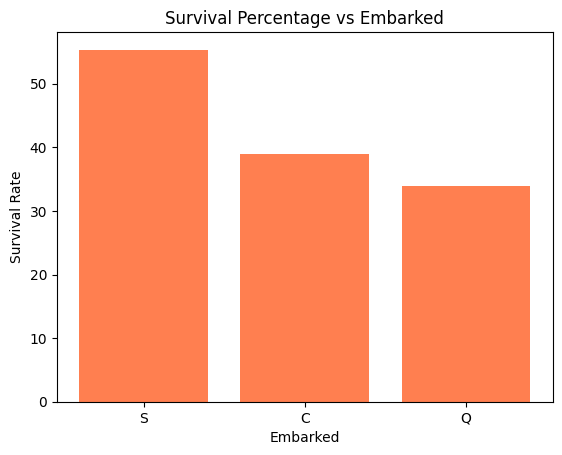

In [26]:
plt.bar(data['Embarked'].unique(), data.groupby('Embarked')['Survived'].mean()*100 ,color='coral')
plt.title("Survival Percentage vs Embarked")
plt.xlabel("Embarked")
plt.ylabel("Survival Rate")
plt.show()

## 7. Survival Rate vs Age Groups

<ipython-input-27-018924bf4eb1>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_by_age=data.groupby('AgeGroup')['Survived'].mean()


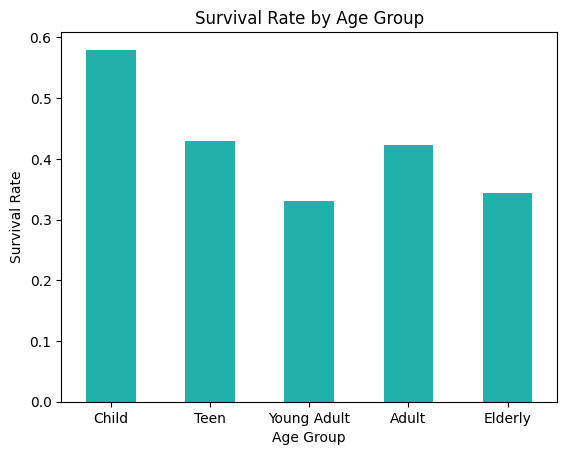

In [27]:
bins = [0, 12, 18, 30, 50, 80]
labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Elderly']
data['AgeGroup'] = pd.cut(data['Age'], bins=bins, labels=labels)

survival_by_age=data.groupby('AgeGroup')['Survived'].mean()
survival_by_age.plot(kind='bar', color='lightseagreen')
plt.title("Survival Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Survival Rate")
plt.xticks(rotation=0)
plt.show()

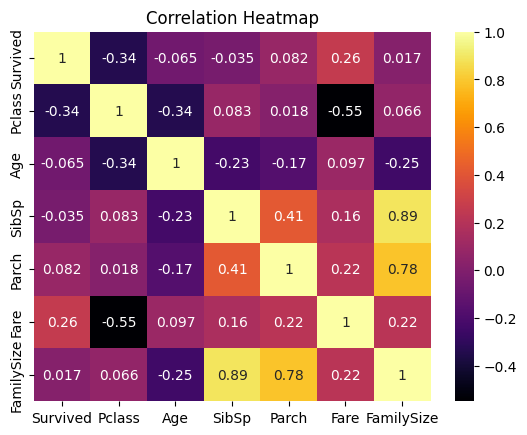

In [28]:
numeric_data=data.select_dtypes(include=['float64','int64'])
sns.heatmap(numeric_data.corr(),annot=True, cmap='inferno')
plt.title("Correlation Heatmap")
plt.show()

Survival rate has some correlation with Fare and very weak correlation with Parch suggesting that wealth and family relations of passengers increased chances of survival.

We have gotten the necessary inferences to proceed with building a model that correctly predicts the survival rates.

# Encoding Categorical Variables

Drop unnecessary columns and convert object data types into numerical data using one hot encoding and mapping.

In [30]:
data['Sex']=data['Sex'].map({'male':0,'female':1})
data=pd.get_dummies(data, columns=['Embarked'])
data.drop(columns=['AgeGroup','Name'],inplace=True)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   FamilySize  891 non-null    int64  
 8   Embarked_C  891 non-null    bool   
 9   Embarked_Q  891 non-null    bool   
 10  Embarked_S  891 non-null    bool   
dtypes: bool(3), float64(2), int64(6)
memory usage: 58.4 KB


## Train Test Split and Scaling Features

In [32]:
x=data.drop(columns='Survived')
y=data['Survived']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [33]:
#Scaled values for models that require scaling
scaler=StandardScaler()
x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled=scaler.transform(x_test)

Let's train 6 different base models including Logistic Regression, Random Forest, Decision Tree, Support Vector Classifier, XGBoost Classifier and determine the accuracy of predictions.

# Model Training

In [34]:
model1=LogisticRegression()
model1.fit(x_train_scaled,y_train)

LogisticRegression()

In [35]:
model2=RandomForestClassifier()
model2.fit(x_train,y_train)

RandomForestClassifier()

In [36]:
model3=DecisionTreeClassifier()
model3.fit(x_train,y_train)

DecisionTreeClassifier()

In [37]:
model4=SVC()
model4.fit(x_train_scaled,y_train)

SVC()

In [38]:
model5=XGBClassifier()
model5.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [39]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model Validation

In [40]:
y_pred=model1.predict(x_test_scaled)
print("Logistic Regression Accuracy",accuracy_score(y_test,y_pred))
print("Classification Report: \n")
print(classification_report(y_test,y_pred))

y_pred=model2.predict(x_test)
print("\nRandom Forest Classifier Accuracy",accuracy_score(y_test,y_pred))
print("Classification Report: \n")
print(classification_report(y_test,y_pred))

y_pred=model3.predict(x_test)
print("\nDecision Tree Classifier Accuracy",accuracy_score(y_test,y_pred))
print("Classification Report: \n")
print(classification_report(y_test,y_pred))

y_pred=model4.predict(x_test_scaled)
print("\nSupport Vector Machine Accuracy",accuracy_score(y_test,y_pred))
print("Classification Report: \n")
print(classification_report(y_test,y_pred))

y_pred=model5.predict(x_test)
print("\nXGBoost Accuracy",accuracy_score(y_test,y_pred))
print("Classification Report: \n")
print(classification_report(y_test,y_pred))

Logistic Regression Accuracy 0.8100558659217877
Classification Report: 

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179


Random Forest Classifier Accuracy 0.8212290502793296
Classification Report: 

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       105
           1       0.78      0.78      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.82      0.82      0.82       179


Decision Tree Classifier Accuracy 0.776536312849162
Classification Report: 

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       105
       

Random Forest Classifier provides the highest accuracy of 82%, followed by SVC and XGBoost Classifier.

# Hyperparameter Tuning

### Random Forest Classifier

In [42]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param={'n_estimators':[100, 300, 500, 700, 1000],'max_depth':[None, 10, 20, 30, 50],'min_samples_split':[2, 5, 10],'min_samples_leaf':[1, 2, 4],'criterion':['gini','entropy'],'max_features':['auto','sqrt','log2']}

rf=RandomizedSearchCV(estimator=model2,param_distributions=param,cv=5,n_iter=100,verbose=2,random_state=42,n_jobs=-1)
rf.fit(x_train,y_train)

print("Best Params of Random Forest Are: ",rf.best_params_)
rf_model=rf.best_estimator_
y_pred_rf=rf_model.predict(x_test)
print("Tuned Random Forest Accuracy: ",accuracy_score(y_test,y_pred_rf))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
145 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
95 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils

Best Params of Random Forest Are:  {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'entropy'}
Tuned Random Forest Accuracy:  0.8435754189944135


In [53]:
#Best Params {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'entropy'}
best_params=rf.best_params_
best_params['n_estimators']=600
best_rf=RandomForestClassifier(**best_params,class_weight='balanced',random_state=42)
best_rf.fit(x_train,y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, min_samples_split=10, n_estimators=600,
                       random_state=42)

In [55]:
y_pred_rf=best_rf.predict(x_test)
print("Best Random Forest Accuracy: ",accuracy_score(y_test,y_pred_rf))

Best Random Forest Accuracy:  0.8435754189944135


Thus, the best accuracy of 84.35% is achieved using Random Forest Classifier after hyperparameter tuning.

<Axes: >

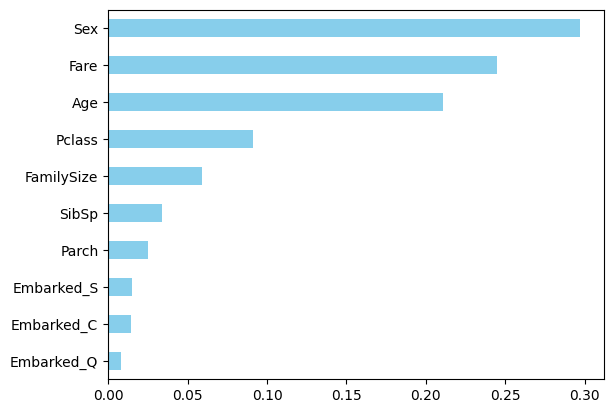

In [56]:
imp=best_rf.feature_importances_
feature_names=x_train.columns
feat_imp=pd.Series(imp, index=feature_names)
feat_imp.sort_values().plot(kind='barh', color='skyblue')

Sex and Fare are two of the most important features that contribute in predicting the survival rate, followed closely by Age. PClass and FamilySize also contribute, though weak.

In [58]:
param={'C':[0.1, 1, 10, 50, 100, 1000],'kernel':['linear', 'rbf'],'gamma':['scale', 0.001, 0.01, 0.1, 1, 'auto']}

svc=RandomizedSearchCV(estimator=model4, param_distributions=param, cv=3, n_iter=30, verbose=2, random_state=42, n_jobs=-1)
svc.fit(x_train_scaled,y_train)

print("Best params of SVC Are: ",svc.best_params_)
svc_model=svc.best_estimator_
y_pred_svc=svc_model.predict(x_test_scaled)
print("Tuned SVC Accuracy: ",accuracy_score(y_test,y_pred_svc))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params of SVC Are:  {'kernel': 'rbf', 'gamma': 0.1, 'C': 10}
Tuned SVC Accuracy:  0.8268156424581006


In [61]:
#Best params:  {'kernel': 'rbf', 'gamma': 0.1, 'C': 10}
best_params_svc=svc.best_params_
best_svc=SVC(**best_params_svc, probability=True, random_state=42)
best_svc.fit(x_train, y_train)

SVC(C=10, gamma=0.1, probability=True, random_state=42)

In [62]:
param={'n_estimators':[100, 300, 500, 1000],'max_depth':[3, 4, 5, 8, 10],'subsample':[0.5, 0.7, 0.8, 1.0],'colsample_bytree':[0.5, 0.7, 1.0], 'learning_rate': [0.1, 0.05, 0.5, 1.0]}

xgb=RandomizedSearchCV(estimator=model5, param_distributions=param, cv=5, n_iter=40, error_score='raise')
xgb.fit(x_train, y_train)

print("Best params of XGBoost Are: ",xgb.best_params_)
xgb_model=xgb.best_estimator_
y_pred_xgb=xgb_model.predict(x_test)
print("Tuned XGBoost Accuracy: ",accuracy_score(y_test,y_pred_xgb))

Best params of XGBoost Are:  {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
Tuned XGBoost Accuracy:  0.8324022346368715


In [84]:
#Best params of XGBoost Are:  {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
best_params_xgb=xgb.best_params_
best_params_xgb['n_estimators']=500
best_params_xgb['subsample']=0.9
best_xgb=XGBClassifier(**best_params_xgb, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_xgb.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:10:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [86]:
y_pred_xgb=best_xgb.predict(x_test)
print("Best XGBoost Accuracy: ",accuracy_score(y_test,y_pred_xgb))

Best XGBoost Accuracy:  0.8379888268156425


# Final Scores

Since Random Forest Classifier performed the best out of the three hypertuned models with an accuracy of 84.35%. The final accuracy scores are as follows:

In [104]:
print("RF Report:\n", classification_report(y_test, y_pred_rf))
print("Best Prediction Accuracy: ",accuracy_score(y_test,y_pred_rf))

RF Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87       105
           1       0.81      0.81      0.81        74

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179

Best Prediction Accuracy:  0.8435754189944135


In [88]:
print(x_train)

     Pclass  Sex   Age  SibSp  Parch      Fare  FamilySize  Embarked_C  \
331       1    0  45.5      0      0   28.5000           0       False   
733       2    0  23.0      0      0   13.0000           0       False   
382       3    0  32.0      0      0    7.9250           0       False   
704       3    0  26.0      1      0    7.8542           1       False   
813       3    1   6.0      4      2   31.2750           6       False   
..      ...  ...   ...    ...    ...       ...         ...         ...   
106       3    1  21.0      0      0    7.6500           0       False   
270       1    0  28.0      0      0   31.0000           0       False   
860       3    0  41.0      2      0   14.1083           2       False   
435       1    1  14.0      1      2  120.0000           3       False   
102       1    0  21.0      0      1   77.2875           1       False   

     Embarked_Q  Embarked_S  
331       False        True  
733       False        True  
382       False      

# Final Predictions

Making final predictions using test.csv.

In [96]:
test_data=pd.read_csv('/content/test.csv')

test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [97]:
test_data.isnull().sum()

,0
PassengerId,0
Pclass,0
Name,0
Sex,0
Age,86
SibSp,0
Parch,0
Ticket,0
Fare,1
Cabin,327


Preprocessing test data as same as train data.

In [98]:
passenger_ids=test_data['PassengerId']

test_data=test_data.drop(columns='Cabin')
test_data['Age']=test_data['Age'].fillna(test_data['Age'].median())
test_data['Embarked']=test_data['Embarked'].fillna(test_data['Embarked'].mode()[0])
test_data['Fare']=test_data['Fare'].fillna(test_data['Fare'].mean())
test_data=test_data.drop(columns=['PassengerId', 'Ticket'])

test_data['FamilySize']=test_data['SibSp']+test_data['Parch']
test_data['Sex']=test_data['Sex'].map({'male':0,'female':1})
test_data=pd.get_dummies(test_data, columns=['Embarked'])
test_data.drop(columns='Name',inplace=True)

In [99]:
x_test=test_data
test_pred = best_rf.predict(x_test)

In [101]:
submission=pd.DataFrame({'PassengerId': passenger_ids,'Survived': test_pred})

submission.to_csv('submission.csv', index=False)